reference: https://wandb.ai/dalle-mini/dalle-mini/reports/CLIP-score-vs-FID-pareto-curves--VmlldzoyMDYyNTAy

# Sampling data

In [ ]:
# load data
import json
coco_path = '/home/tiger/project/dataset/coco'
data_file = f'{coco_path}/annotations/captions_val2014.json'
data = json.load(open(data_file))


# merge images and annotations
import pandas as pd
images = data['images']
annotations = data['annotations']
df = pd.DataFrame(images)
df_annotations = pd.DataFrame(annotations)
df = df.merge(pd.DataFrame(annotations), how='left', left_on='id', right_on='image_id')


# keep only the relevant columns
df = df[['file_name', 'caption']]


# shuffle the dataset
df = df.sample(frac=1)


# remove duplicate images
df = df.drop_duplicates(subset='file_name')


# create a random subset
n_samples = 10000
df_sample = df.sample(n_samples)


# save the sample to a parquet file
df_sample.to_parquet(f'{coco_path}/subset.parquet')


# copy the images to reference folder
from pathlib import Path
import shutil
subset_path = Path(f'{coco_path}/subset')
subset_path.mkdir(exist_ok=True)
for i, row in df_sample.iterrows():
    path = f'{coco_path}/val2014/' + row['file_name']
    shutil.copy(path, f'{coco_path}/subset/')


In [ ]:
# center crop the images
def center_crop_images(folder, output_folder, size):
    # coco images are not square, so we need to center crop them
    from PIL import Image
    import os
    os.makedirs(output_folder, exist_ok=True)
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = Image.open(image_path)
        width, height = image.size
        left = (width - size) / 2 if width > size else 0
        top = (height - size) / 2 if height > size else 0
        right = (width + size) / 2 if width > size else width
        bottom = (height + size) / 2 if height > size else height
        image = image.crop((left, top, right, bottom))
        image = image.resize((size, size))  # resize non-square images
        image.save(os.path.join(output_folder, file))

folder_name = '/home/tiger/project/dataset/coco/subset'
output_folder = '/home/tiger/project/dataset/coco/subset_cropped'
center_crop_images(folder_name, output_folder, 320)

# Load subset as dataloader

In [5]:
# load the subset
from torch.utils.data import Dataset, DataLoader
import pandas as pd 

class COCOCaptionSubset(Dataset):
    def __init__(self, path, transform=None):
        self.df = pd.read_parquet(path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return row['file_name'], row['caption']

# testing 
coco_path = '/home/tiger/project/dataset/coco'
coco_cache_file = f'{coco_path}/subset.parquet'     # sampled subsets
cocosubset = COCOCaptionSubset(coco_cache_file)
cocosubsetloader = DataLoader(cocosubset, batch_size=64, shuffle=False, num_workers=8)


# Generating Images Via T2I Model

In [ ]:
# demo inference, use coco_sample_generator.py to generate more
# load the t2i model
# from diffusers import StableDiffusionPipeline
# stable_diffusion = StableDiffusionPipeline.from_pretrained("/home/tiger/project/pretrained_models/stable-diffusion-v1-4").to('cuda')   

# sample_step = 20
# guidance_scale = 1.5

# import os

# output_path = f'./output_gs{guidance_scale}_ss{sample_step}'
# os.makedirs(output_path, exist_ok=True)

# for i, (image_paths, captions) in enumerate(cocosubsetloader):
#     outputs = stable_diffusion(list(captions), num_inference_steps=sample_step, guidance_scale=guidance_scale).images
#     for j, image_path in enumerate(image_paths):
#         image_path = image_path.replace('/', '_')
#         image_path = os.path.join(output_path, image_path)
#         outputs[j].save(image_path)
#     break

In [1]:
import torch
device = torch.device('cuda')

coco_subset_crop_path = '/home/tiger/project/dataset/coco/subset_cropped'
output_root = '/home/tiger/project/position-guided-t2i/output'
output_paths = [os.path.join(output_root, out) for out in sorted(os.listdir(output_root))]


In [2]:
# fid score

# !pip install pytorch_fid
# !python -m pytorch_fid /home/tiger/project/dataset/coco/subset_cropped /home/tiger/project/position-guided-t2i/output/gs2.0_ss20

from pytorch_fid.fid_score import calculate_fid_given_paths

fids = []
for output_path in output_paths:
    fid_value = calculate_fid_given_paths([coco_subset_crop_path, output_path], batch_size=200, device=device, dims=2048, num_workers=8)
    fids.append(fid_value)
    print(output_path, fid_value)

/home/tiger/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tiger/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


/home/tiger/project/position-guided-t2i/output/gs1.5_ss20 22.765903388613765


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


/home/tiger/project/position-guided-t2i/output/gs2.0_ss20 18.159921113816665


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


/home/tiger/project/position-guided-t2i/output/gs3.0_ss20 15.94397287378655


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


/home/tiger/project/position-guided-t2i/output/gs4.0_ss20 16.315106185605657


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


/home/tiger/project/position-guided-t2i/output/gs5.0_ss20 17.35088805364785


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


/home/tiger/project/position-guided-t2i/output/gs6.0_ss20 17.933771904354728


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


/home/tiger/project/position-guided-t2i/output/gs7.0_ss20 19.059673548019532


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


/home/tiger/project/position-guided-t2i/output/gs8.0_ss20 20.12984543749127


In [3]:
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from PIL import Image
import numpy as np
from tqdm import tqdm


def load_clip_model(model_path='openai/clip-vit-large-patch14'):
    # text_encoder = BertModel.from_pretrained(model_path).eval().cuda()
    # text_tokenizer = BertTokenizer.from_pretrained(model_path)
    clip_model = CLIPModel.from_pretrained(model_path)
    processor = CLIPProcessor.from_pretrained(model_path)
    tokenizer = CLIPTokenizer.from_pretrained(model_path)

    clip_model = clip_model.eval().cuda()
    return clip_model, processor, tokenizer


def clip_score(clip_model, processor, tokenizer, dataloader, output_image_path):
    all_image_features = []
    all_text_features = []
    for (i, (image_paths, captions)) in enumerate(tqdm(dataloader)):
        # print(image_paths, captions)
        text_inputs = tokenizer(list(captions), padding=True, return_tensors="pt").to('cuda')
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.detach().cpu().numpy()
        all_text_features.append(text_features)

        # vit 速度比较龟
        images = [Image.open(os.path.join( output_image_path , image_path)) for image_path in image_paths]
        image_inputs = processor(images = images, return_tensors="pt").to('cuda')
        image_features = clip_model.get_image_features(**image_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.detach().cpu().numpy()
        all_image_features.append(image_features)

        # NOTE testing 等太久了，抽样吧... 需要全部的话，把这个 if 去掉
        if i == 10:
            break

    all_text_features = np.concatenate(all_text_features, axis=0)
    all_image_features = np.concatenate(all_image_features, axis=0)
    mean_similarity = (all_image_features @ all_text_features.T).diagonal().mean()
    return mean_similarity


In [6]:
clip_model_path="/home/tiger/project/pretrained_models/clip-vit-large-patch14"
clip_model, processor, tokenizer = load_clip_model(clip_model_path)
clip_scores = []
for output_path in output_paths:
    clip_score_each = clip_score(clip_model, processor, tokenizer, cocosubsetloader, output_path)   # 3min ....
    print(output_path, clip_score_each)
    clip_scores.append(clip_score_each)

  6%|▋         | 10/157 [00:15<03:45,  1.54s/it]


/home/tiger/project/position-guided-t2i/output/gs1.5_ss20 0.23490335


  6%|▋         | 10/157 [00:14<03:39,  1.50s/it]


/home/tiger/project/position-guided-t2i/output/gs2.0_ss20 0.24406949


  6%|▋         | 10/157 [00:15<03:41,  1.51s/it]


/home/tiger/project/position-guided-t2i/output/gs3.0_ss20 0.25112092


  6%|▋         | 10/157 [00:14<03:39,  1.49s/it]


/home/tiger/project/position-guided-t2i/output/gs4.0_ss20 0.25709876


  6%|▋         | 10/157 [00:14<03:37,  1.48s/it]


/home/tiger/project/position-guided-t2i/output/gs5.0_ss20 0.25781947


  6%|▋         | 10/157 [00:14<03:40,  1.50s/it]


/home/tiger/project/position-guided-t2i/output/gs6.0_ss20 0.2593051


  6%|▋         | 10/157 [00:14<03:37,  1.48s/it]


/home/tiger/project/position-guided-t2i/output/gs7.0_ss20 0.26007786


  6%|▋         | 10/157 [00:14<03:37,  1.48s/it]

/home/tiger/project/position-guided-t2i/output/gs8.0_ss20 0.2596085


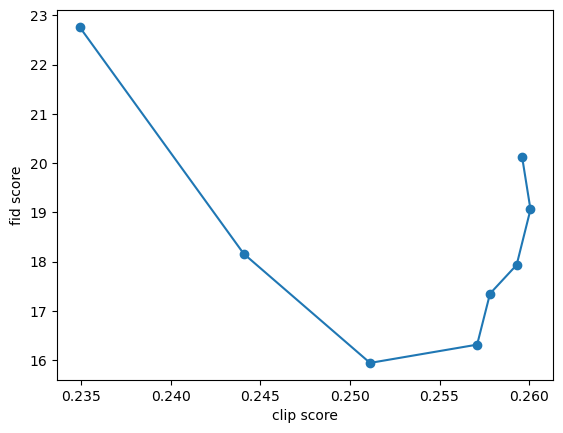

In [7]:
# plot clip score as x-axis, fid score as y-axis, line chart
import matplotlib.pyplot as plt
plt.plot(clip_scores, fids, 'o-')
plt.xlabel('clip score')
plt.ylabel('fid score')
plt.show()